In [1]:
import re
import numpy as np
import pandas as pd

from plotting import Plot, ModelEvaluation
from time_series import TsHandler
from preprocess import Preprocessor, Dataset
from multi_horizon import Prediction

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_sales = pd.read_csv('./data/sales_train_evaluation.csv')
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [3]:
# agg to item lvl for obtaining a single time series with obvious patterns
df = df_sales.drop(columns=[
    'id',
    # 'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
    ])
df_item_id = df.groupby(['item_id']).sum()
df_item_id

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,8,6,11,9,7,7,10,6,5
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,...,15,16,25,9,7,25,19,25,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,5,4,1,3,2,4,2,8,7,5,...,5,7,11,4,8,3,4,5,4,7
HOUSEHOLD_2_513,0,0,0,0,0,0,0,0,0,0,...,4,0,5,3,6,3,0,9,3,4
HOUSEHOLD_2_514,4,8,2,1,1,2,3,8,2,1,...,2,2,2,6,1,0,1,4,3,3


In [4]:
# find the max of sum(sales) all over the time (~= more obvious pattern)
df_item_id.sum(axis=1).sort_values(ascending=False)

item_id
FOODS_3_090        1017916
FOODS_3_586         932236
FOODS_3_252         573723
FOODS_3_555         497881
FOODS_3_587         402159
                    ...   
HOBBIES_2_084          786
HOUSEHOLD_2_005        782
HOUSEHOLD_2_175        759
HOBBIES_2_119          673
HOUSEHOLD_2_101        593
Length: 3049, dtype: int64

In [5]:
# Show top 10 items
desc_index = df_item_id.sum(axis=1).sort_values(ascending=False).index[:10]
df_top10 = df_item_id.reindex(desc_index)
df_top10

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_090,1046,1036,673,642,531,877,1117,1311,1306,517,...,638,736,675,374,369,380,400,626,682,679
FOODS_3_586,516,479,328,376,319,430,405,624,537,432,...,458,499,556,364,415,375,334,451,498,583
FOODS_3_252,289,273,157,172,132,218,227,363,255,204,...,326,430,378,272,318,330,225,309,345,416
FOODS_3_555,321,315,214,204,159,265,240,425,355,224,...,255,256,269,209,188,215,212,279,295,320
FOODS_3_587,298,353,234,310,205,214,190,572,508,428,...,194,233,352,233,160,190,170,216,240,294
FOODS_3_714,238,215,141,144,96,139,169,277,219,166,...,196,282,238,177,226,219,156,228,268,259
FOODS_3_694,291,230,187,200,136,234,254,325,251,200,...,242,246,255,200,207,178,187,233,248,255
FOODS_3_226,210,168,119,165,116,199,191,235,171,173,...,187,229,251,147,166,171,183,218,246,255
FOODS_3_202,106,113,65,80,75,90,98,133,168,91,...,180,197,233,187,119,126,137,170,182,251


In [6]:
Plot.plot_multi_ts(df_top10)

### Single time series
- FOODS_3_555 (purple)

In [7]:
df_s = TsHandler.create_single_time_series(df_item_id, name='FOODS_3_555')
# df_s = TsHandler.create_diff(df_s)    # do not need diff as already knew diff(1) is stationary (I tried)
df_s

,sales
0,321
1,315
2,214
3,204
4,159
...,...
1936,215
1937,212
1938,279
1939,295


### ARIMA

In [8]:
# params
HORIZON = 28

In [9]:
train = df_s.iloc[:-HORIZON]
valid = df_s.iloc[-HORIZON:]

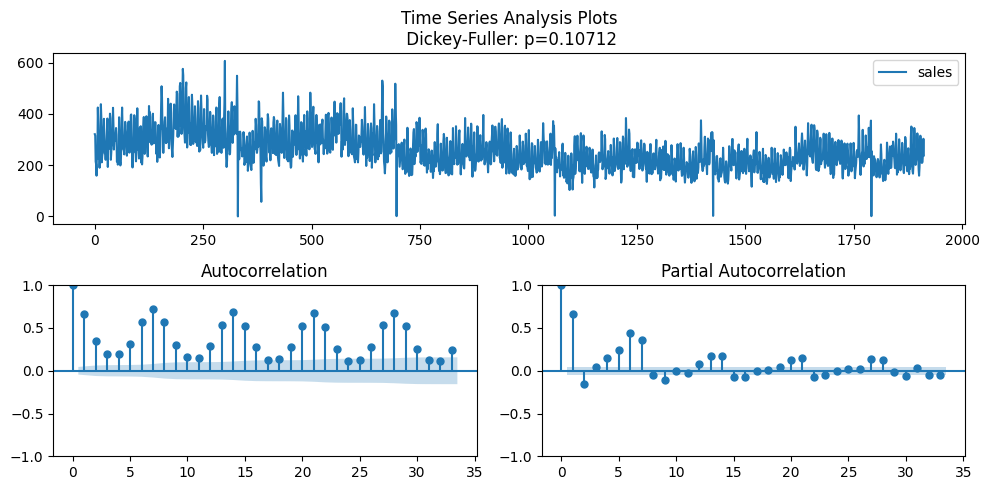

In [10]:
Plot.arima_plot(train)

In [11]:
from sktime.forecasting.arima import AutoARIMA

arima = AutoARIMA(d=1, suppress_warnings=True)
arima.fit(train)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1913
Model:               SARIMAX(5, 1, 3)   Log Likelihood               -9930.472
Date:                Fri, 08 Sep 2023   AIC                          19878.945
Time:                        16:36:27   BIC                          19928.948
Sample:                             0   HQIC                         19897.346
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5380      0.097      5.557      0.000       0.348       0.728
ar.L2         -0.6967      0.073     -9.514      0.000      -0.840      -0.553
ar.L3         -0.2669      0.075     -3.565      0.000      -0.414      -0.120
ar.L4         -0.2251      0.025     -9.070      0.000      -0.274      -0.176
ar.L5         -0.2828      0.043     -6.633      0.000      -0.366      -0.199
ma.L1         -1.0830      0.098    -10.999      0.000      -1.276      -0.890
ma.L2          0.7918      0.123      6.443      0.000       0.551       1.033
ma.L3          0.0880      0.093      0.950      0.342      -0.094       0.270
sigma2      1980.0753     30.317     65.312      0.000    1920.654    2039.496
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             10875.70
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

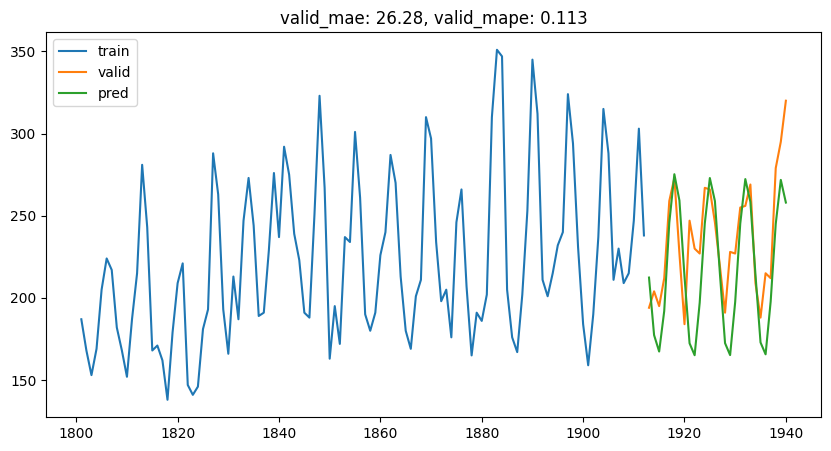

In [12]:
fh = np.arange(len(valid)) + 1
pred = arima.predict(fh=fh)

valid_mae_arima, valid_mape_arima = Plot.plot_forecast(train.iloc[-HORIZON*4:], valid, pred)

### LGBM

In [13]:
# params
WINDOWSIZE = 6

In [14]:
# Convert time series to tabular format
df = TsHandler.tabularise_single_ts(df_s['sales'].values, window_size=WINDOWSIZE, step=1)
display(df_s.T)
df

,0,1,2,3,4,5,6,7,8,9,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
sales,321,315,214,204,159,265,240,425,355,224,...,255,256,269,209,188,215,212,279,295,320


,x1,x2,x3,x4,x5,x6,y1
0,321,315,214,204,159,265,240
1,315,214,204,159,265,240,425
2,214,204,159,265,240,425,355
3,204,159,265,240,425,355,224
4,159,265,240,425,355,224,253
...,...,...,...,...,...,...,...
1930,227,255,256,269,209,188,215
1931,255,256,269,209,188,215,212
1932,256,269,209,188,215,212,279
1933,269,209,188,215,212,279,295


In [15]:
# train valid test split
df = Preprocessor.set_train_valid_test(df, horizon=HORIZON)
df

,x1,x2,x3,x4,x5,x6,y1,train_valid_test
0,321,315,214,204,159,265,240,TRAIN
1,315,214,204,159,265,240,425,TRAIN
2,214,204,159,265,240,425,355,TRAIN
3,204,159,265,240,425,355,224,TRAIN
4,159,265,240,425,355,224,253,TRAIN
...,...,...,...,...,...,...,...,...
1930,227,255,256,269,209,188,215,VALID
1931,255,256,269,209,188,215,212,VALID
1932,256,269,209,188,215,212,279,VALID
1933,269,209,188,215,212,279,295,VALID


In [16]:
num_cols = [f"x{i+1}" for i in range(WINDOWSIZE)]
target_col = 'y1'

dataset_all = Dataset(df, cat_cols=[], num_cols=num_cols, target_col=target_col)

In [17]:
import lightgbm as lgbm

lgbm_params= {
    "objective" : "l1",
    "metric" : ["rmse"],
    "learning_rate" : 0.01,
}
lgbm_trainer_args= {
    "num_boost_round": 1000,
    "early_stopping_rounds": 100,
    "verbose_eval": 10
}

lgbm_model = lgbm.train(
    lgbm_params,
    **lgbm_trainer_args,
    train_set=dataset_all.create_lgbm_dataset("TRAIN"),
    valid_sets=dataset_all.create_lgbm_dataset("VALID"),
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1907, number of used features: 6
[LightGBM] [Info] Start training from score 245.500000
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 33.2355
[20]	valid_0's rmse: 31.3055
[30]	valid_0's rmse: 29.6912
[40]	valid_0's rmse: 28.815
[50]	valid_0's rmse: 28.1331
[60]	valid_0's rmse: 27.5639
[70]	valid_0's rmse: 27.4667
[80]	valid_0's rmse: 27.452
[90]	valid_0's rmse: 27.3259
[100]	valid_0's rmse: 27.2503
[110]	valid_0's rmse: 27.2248
[120]	valid_0's rmse: 27.1947
[130]	valid_0's rmse: 27.1458
[140]	valid_0's rmse: 27.1788
[150]	valid_0's rmse: 27.1762
[160]	valid_0's rmse: 27.1584
[170]	valid_0's rmse: 27.1151
[180]	valid_0's rmse: 27.1376
[190]	valid_0's rmse: 27.2011
[200]	valid_0's rmse: 27.2357
[210

In [18]:
ModelEvaluation.plot_lgbm_feature_importance(lgbm_model)

extracting feature importance (gain/split)....


In [19]:
y_pred_lgbm = lgbm_model.predict(dataset_all.create_lgbm_dataset("VALID").data)
y_pred_lgbm

array([219.94529433, 203.07629038, 207.32664524, 225.4360501 ,
       243.92331886, 270.10571863, 243.67825148, 207.15190062,
       192.44348181, 239.97693368, 245.58552985, 256.52616879,
       250.81012979, 210.86751395, 263.41607289, 210.9003632 ,
       208.87396196, 230.68659784, 245.23826717, 272.2884374 ,
       239.0456026 , 233.46517467, 214.61161937, 207.45385324,
       231.67857487, 235.1564501 , 287.08126579, 244.11653564])

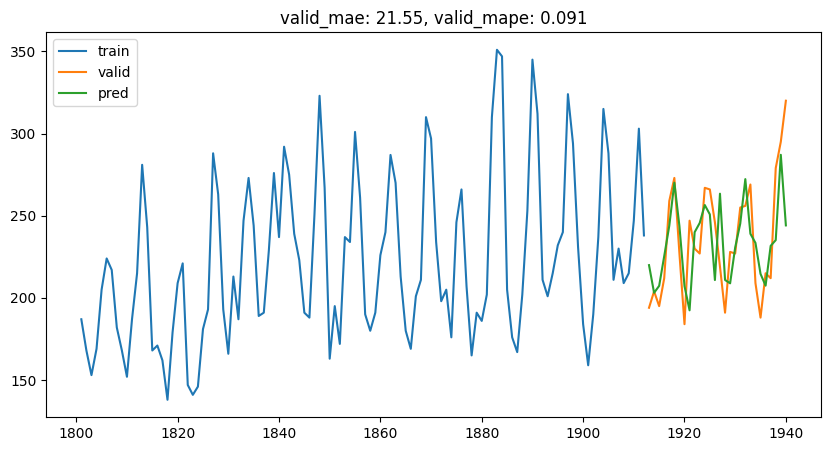

In [20]:
valid_mae_lgbm, valid_mape_lgbm = Plot.plot_forecast(train.iloc[-HORIZON*4:], valid, pd.DataFrame(y_pred_lgbm, columns=['y_pred_lgbm']))

### Attention
- ARIMA: valid_mape: 0.113
- LGBM: valid_mape: 0.091
- It is unfair to compare the result like that
    - As LGBM is predicting the next timestep (single output) while the actual problem is multi-horizon
    - Imagine now u have to predict the test set, then u will understand :D

### Multi-horizon prediction using ML model
- Multi-horizon prediction: predict multi timesteps (in this case: 28 future timesteps)
- While it is very easy to do so using stat model like ARIMA
    - just fit all the data and then predict the next 28 days
- It is a little bit tricky for using ML model like LGBM since it only predict the next timestep
    - Recurrent approach
        - Prediction(t+1) = model(obs(t), obs(t-1), …, obs(t-w))
        - Prediction(t+2) = model(prediction(t+1) , obs(t), obs(t-1), …, obs(t-w+1))
    - Direct multi-horizon approach
        - Prediction(t+1) = model_1(obs(t), obs(t-1), …, obs(t-w))
        - Prediction(t+2) = model_2(obs(t), obs(t-1), …, obs(t-w))
        - ...
        - Prediction(t+n) = model_n(obs(t), obs(t-1), …, obs(t-w))

    

## Recurrent approach

In [21]:
trainset_last_row = dataset_all.create_lgbm_dataset("TRAIN").data.iloc[-1].values
trainset_last_row

array([211, 230, 209, 215, 247, 303], dtype=int64)

In [22]:
y_pred_recurrent = Prediction.recurrent_predict(lgbm_model, trainset_last_row, horizon=HORIZON)
y_pred_recurrent

array([[268.51620942],
       [219.23170101],
       [206.30108722],
       [207.54550601],
       [231.0443182 ],
       [247.07984656],
       [286.18932395],
       [264.2508698 ],
       [207.21119481],
       [206.33839432],
       [209.06005327],
       [231.52842871],
       [263.79519973],
       [282.54786398],
       [242.01014239],
       [206.86961651],
       [206.46048656],
       [209.28171122],
       [234.89369834],
       [273.77991318],
       [284.19738258],
       [243.52400484],
       [207.16330429],
       [206.46048656],
       [209.46988545],
       [228.80912753],
       [252.02369678],
       [279.5932109 ]])

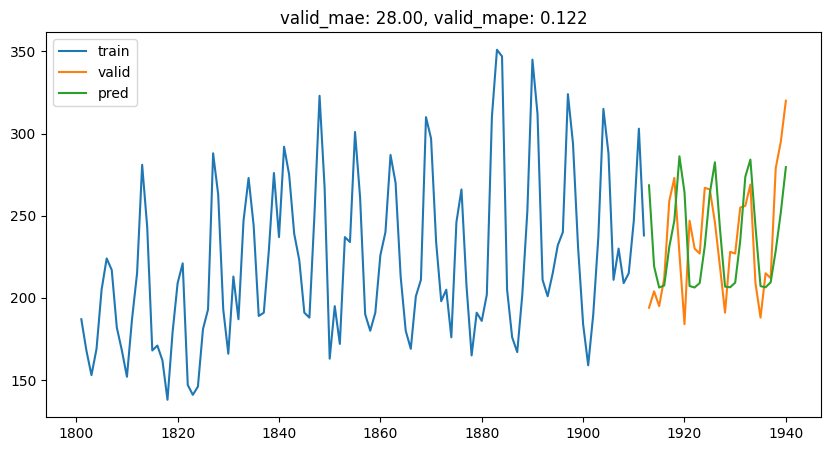

In [23]:
valid_mae_lgbm, valid_mape_lgbm = Plot.plot_forecast(train.iloc[-HORIZON*4:], valid, pd.DataFrame(y_pred_recurrent, columns=['y_pred_recurrent']))

- LGBM(recurrent) is no better than ARIMA (valid_mape, lgbm: 0.122 vs ARIMA: 0.113)

## Direct multi-horizon approach
- 28 horizon = 
- 28 steps: EACH step: 1 model input data, set train_valid_test, train lgbm model, predict with single output. Finally concat those 28 output -> 1 y_pred_concated

In [24]:
df_s.T

,0,1,2,3,4,5,6,7,8,9,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
sales,321,315,214,204,159,265,240,425,355,224,...,255,256,269,209,188,215,212,279,295,320


In [25]:
df1 = TsHandler.tabularise_single_ts(df_s['sales'].values, window_size=WINDOWSIZE, step=1)
df1

,x1,x2,x3,x4,x5,x6,y1
0,321,315,214,204,159,265,240
1,315,214,204,159,265,240,425
2,214,204,159,265,240,425,355
3,204,159,265,240,425,355,224
4,159,265,240,425,355,224,253
...,...,...,...,...,...,...,...
1930,227,255,256,269,209,188,215
1931,255,256,269,209,188,215,212
1932,256,269,209,188,215,212,279
1933,269,209,188,215,212,279,295


In [26]:
df2 = TsHandler.tabularise_single_ts(df_s['sales'].values, window_size=WINDOWSIZE, step=2)
df2

,x1,x2,x3,x4,x5,x6,y2
0,321,315,214,204,159,265,425
1,315,214,204,159,265,240,355
2,214,204,159,265,240,425,224
3,204,159,265,240,425,355,253
4,159,265,240,425,355,224,190
...,...,...,...,...,...,...,...
1929,228,227,255,256,269,209,215
1930,227,255,256,269,209,188,212
1931,255,256,269,209,188,215,279
1932,256,269,209,188,215,212,295


In [27]:
df2 = Preprocessor.set_train_valid_test(df2, horizon=HORIZON)
df2

,x1,x2,x3,x4,x5,x6,y2,train_valid_test
0,321,315,214,204,159,265,425,TRAIN
1,315,214,204,159,265,240,355,TRAIN
2,214,204,159,265,240,425,224,TRAIN
3,204,159,265,240,425,355,253,TRAIN
4,159,265,240,425,355,224,190,TRAIN
...,...,...,...,...,...,...,...,...
1929,228,227,255,256,269,209,215,VALID
1930,227,255,256,269,209,188,212,VALID
1931,255,256,269,209,188,215,279,VALID
1932,256,269,209,188,215,212,295,VALID


In [30]:
lgbm_params= {
    "objective" : "l1",
    "metric" : ["rmse"],
    "learning_rate" : 0.01,
}
lgbm_trainer_args= {
    "num_boost_round": 1000,
    "early_stopping_rounds": 100,
    "verbose_eval": 100
}

y_pred_concat, list_lgbm_model = Prediction.direct_multi_output_approach(
    df_s, 
    col='sales', 
    windowsize=WINDOWSIZE, 
    horizon=HORIZON, 
    lgbm_params=lgbm_params, 
    lgbm_trainer_args=lgbm_trainer_args, 
    show_plot=False
)

---------------------Step1---------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1907, number of used features: 6
[LightGBM] [Info] Start training from score 245.500000
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 27.2503
[200]	valid_0's rmse: 27.2357
Early stopping, best iteration is:
[173]	valid_0's rmse: 27.0929
---------------------Step2---------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1906, number of used features: 6
[LightGBM] [Info] Start training from score 246.000000
Training until validation s

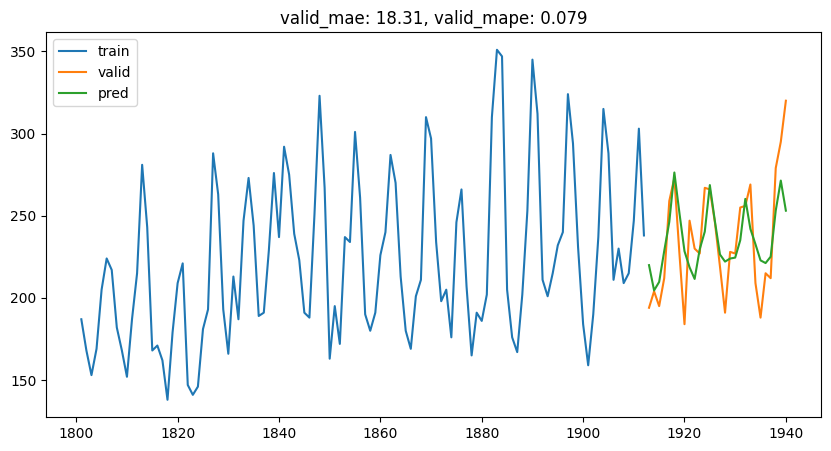

In [31]:
valid_mae_lgbm, valid_mape_lgbm = Plot.plot_forecast(train.iloc[-HORIZON*4:], valid, pd.DataFrame(y_pred_concat, columns=['y_pred_multi_model']))

- LGBM(multi model approach) is better than recurrent approach (valid_mape, multi-model: 0.079 vs recurrent: 0.122 vs ARIMA: 0.113)
- but hard to manage 28 trained model
- also hard for analysis